In [2]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
from scipy.signal import find_peaks_cwt as peakFinder
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
from sklearn.utils import shuffle as mutualShuf
import datetime
%matplotlib inline

# Import and process data

In [3]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    return classData, coilData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

classData, coilData = importPickle("./inData/6060DataFrame.pkl")
# Replace outlier reading 138 (far far too big!)
classData[138] = classData[137]
coilData[138] = coilData[137]

illData, healthData = splitData(coilData, classData)
illUnseen = np.vstack(np.array(illData[:20]))#[:,::40]
healthUnseen = np.vstack(np.array(healthData[:20]))#[:,::40]
illData = np.vstack(np.array(illData[20:]))#[:,::40]
healthData = np.vstack(np.array(healthData[20:]))#[:,::40]
print(illData.shape, healthData.shape,"\n", illUnseen.shape, healthUnseen.shape)

(2625, 2000) (2775, 2000) 
 (300, 2000) (300, 2000)


375


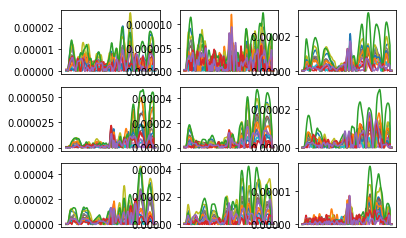

In [4]:
# Various plots...
r = randint(0,390)
print(r)
fig, ax = plt.subplots(3,3)
for i in np.arange(0,ax.shape[0],1):
    for j in np.arange(0,ax.shape[1],1):
        r = r+1
        for k in np.arange(0,15):
            ax[i,j].plot(np.abs(coilData[r][k, 0:2000]))
            ax[i,j].set_xticks([])

In [13]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def functionTown(illArr, healthArr, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    
    print("ill samples", len(illArr))
    print("healthy samples", len(healthArr))
    
    classData = []
    for i in np.arange(0, len(illArr), 1):
        classData.append(1)
    for i in np.arange(0, len(healthArr), 1):
        classData.append(0)
    ecgData = np.reshape(np.append(illArr, healthArr), (-1,2000))
    
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)
        
    classDataOH = processClassData(classData)
    return np.array(ecgData), classDataOH, classData
    
ecgData, classDataOH, classData = functionTown(illData, healthData, True)
# Reintegrate the found values...
ecgData = np.cumsum(ecgData, axis=1)
ecgData = np.reshape(ecgData, (-1,2000,1))
# Split ecgData into k sets so we can perform k-fold cross validation:
k = 1
kfoldData = np.array_split(ecgData, k)
kfoldLabelsOH = np.array_split(classDataOH, k)
kfoldLabels = np.array_split(classData, k)

# Get the unseen data:
unseenData, unseenClassOH, unseenClass = functionTown(illUnseen, healthUnseen, True)
unseenData =  np.cumsum(unseenData, axis=1)
unseenData = np.reshape(unseenData, (-1,2000,1))
iUnseen, hUnseen = splitData(unseenData, unseenClass)
unseenHL = np.tile([1,0], (len(hUnseen), 1))
unseenIL = np.tile([0,1], (len(iUnseen), 1))

ill samples 2625
healthy samples 2775
ill samples 300
healthy samples 300


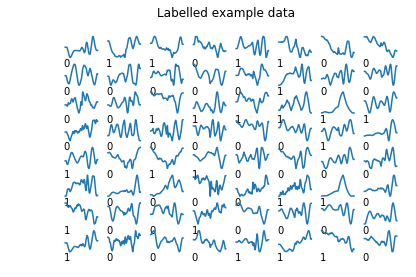

In [14]:
visualiseData(ecgData, classData, 8, False)
#plt.savefig("./outData/figures/messy_mcg_example300buf.pdf")

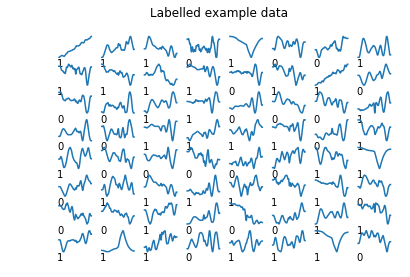

In [15]:
visualiseData(unseenData, unseenClass, 8, False)

# Neural Network

In [16]:
healthEval = []
illEval = []
spec = []
sens = []
unseenSpec = []
unseenSens = []
unseenAvg = []

In [17]:
if k != 1:
    for i in np.arange(0,k,1):
        sess = tf.InteractiveSession()
        tf.reset_default_graph()
        tflearn.initializations.normal()

        # Input layer:
        net = tflearn.layers.core.input_data(shape=[None, 2000, 1])

        # First layer:
        net = tflearn.layers.conv.conv_1d(net, 16, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Second layer:
        net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)
        
        # Third layer (added)
        net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Fully connected layer 1:
        net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

        # Dropout layer:
        net = tflearn.layers.core.dropout(net, keep_prob=0.5)

        # Output layer:
        net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

        net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                                 learning_rate=0.0001)

        model = tflearn.DNN(net, tensorboard_verbose=3)
        dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 2000, 1])
        dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
        model.fit(dummyData, dummyLabels, n_epoch=5, show_metric=True)

        illTest = []
        healthTest = []
        for index, item in enumerate(kfoldLabels[i]):
            if item == 1:
                illTest.append(kfoldData[i][index])
            if item == 0:
                healthTest.append(kfoldData[i][index])

        healthLabel = np.tile([1,0], (len(healthTest), 1))
        illLabel = np.tile([0,1], (len(illTest), 1))

        sens.append(model.evaluate(np.array(healthTest), healthLabel))
        spec.append(model.evaluate(np.array(illTest), illLabel))
    
        unseenAvg.append(model.evaluate(unseenData, unseenClassOH))
        unseenSpec.append(model.evaluate(np.array(iUnseen), unseenIL))
        unseenSens.append(model.evaluate(np.array(hUnseen), unseenHL))

if k == 1:
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, 2000, 1])

    # First layer:
    net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_1d(net, 2)

    # Second layer:
    net = tflearn.layers.conv.conv_1d(net, 128, 5, activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_1d(net, 2)

    # Fully connected layer 1:
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

    # Dropout layer:
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

    net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                             learning_rate=0.001)

    model = tflearn.DNN(net, tensorboard_verbose=3)
    model.fit(ecgData, classDataOH, n_epoch=5, validation_set=0.1, show_metric=True)

Training Step: 82  | total loss: 0.66393
| Adam | epoch: 001 | loss: 0.66393 - acc: 0.5843 -- iter: 0384/4860


KeyboardInterrupt: 

In [12]:
if k != 1:
    print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens),\
         "\nUnseen Spec:", unseenSpec, "\nUnseen Sens:", unseenSens, "\nUnseen Avg:", unseenAvg)

else:
    print(model.evaluate(unseenData, unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen), unseenIL),"\n",\
    model.evaluate(np.array(hUnseen), unseenHL))

Specificity: [[0.69675925705167985], [0.77802944534362239], [0.88041002413678005], [0.077546296020348862], [0.0], [0.0]] 
Avg: 0.405457503759 
Sensitivity: [[0.5662393167487576], [0.48745910636471296], [0.33188720205859351], [1.0], [1.0], [1.0]] 
Avg: 0.730930937529 
Unseen Spec: [[0.72333333412806189], [0.75333333651224776], [0.87666666825612383], [0.14333333383003871], [0.003333333432674408], [0.0]] 
Unseen Sens: [[0.53666666666666663], [0.4500000019868215], [0.32000000039736431], [1.0], [1.0], [1.0]] 
Unseen Avg: [[0.63000000317891436], [0.60166666666666668], [0.59833333015441892], [0.57166666825612389], [0.50166666746139521], [0.49999999801317851]]
